Action data shape: (24, 200, 6)
Hand to ball: [0.00000000e+00 9.92401990e-01 5.55111508e-09] 
Ball position: [] 
Target position: []


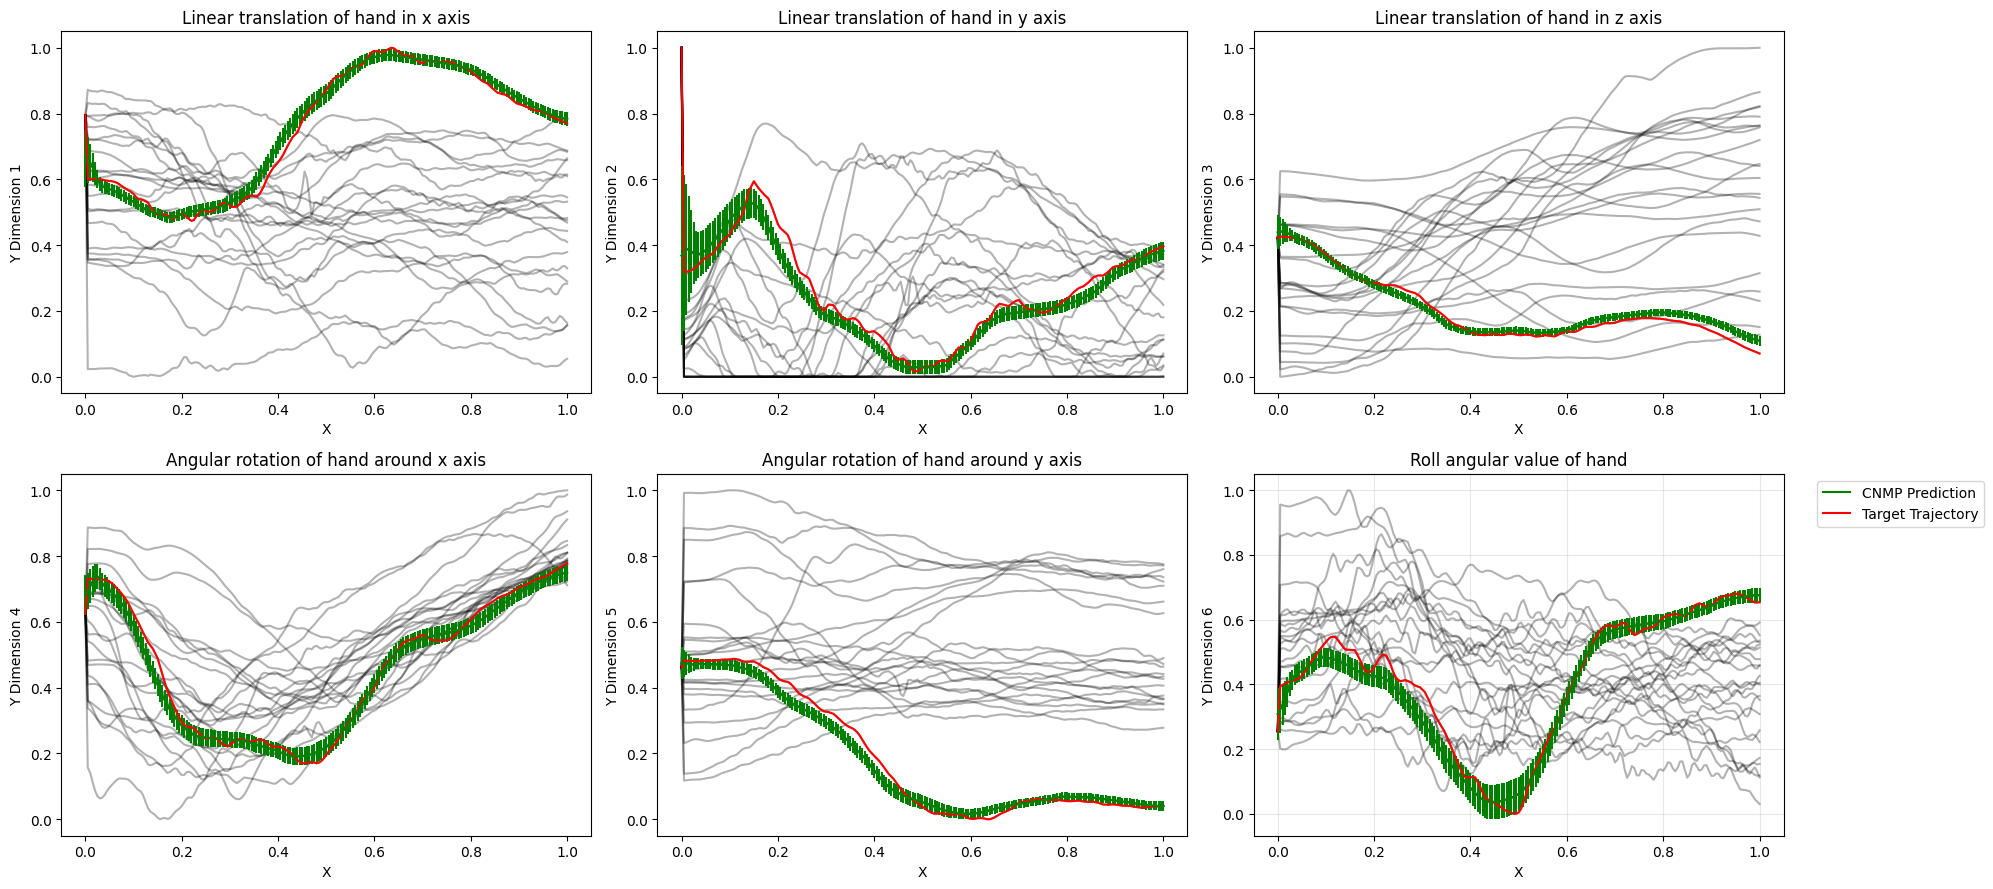

Hand to ball: [0.26853853 0.11938778 0.        ] 
Ball position: [] 
Target position: []


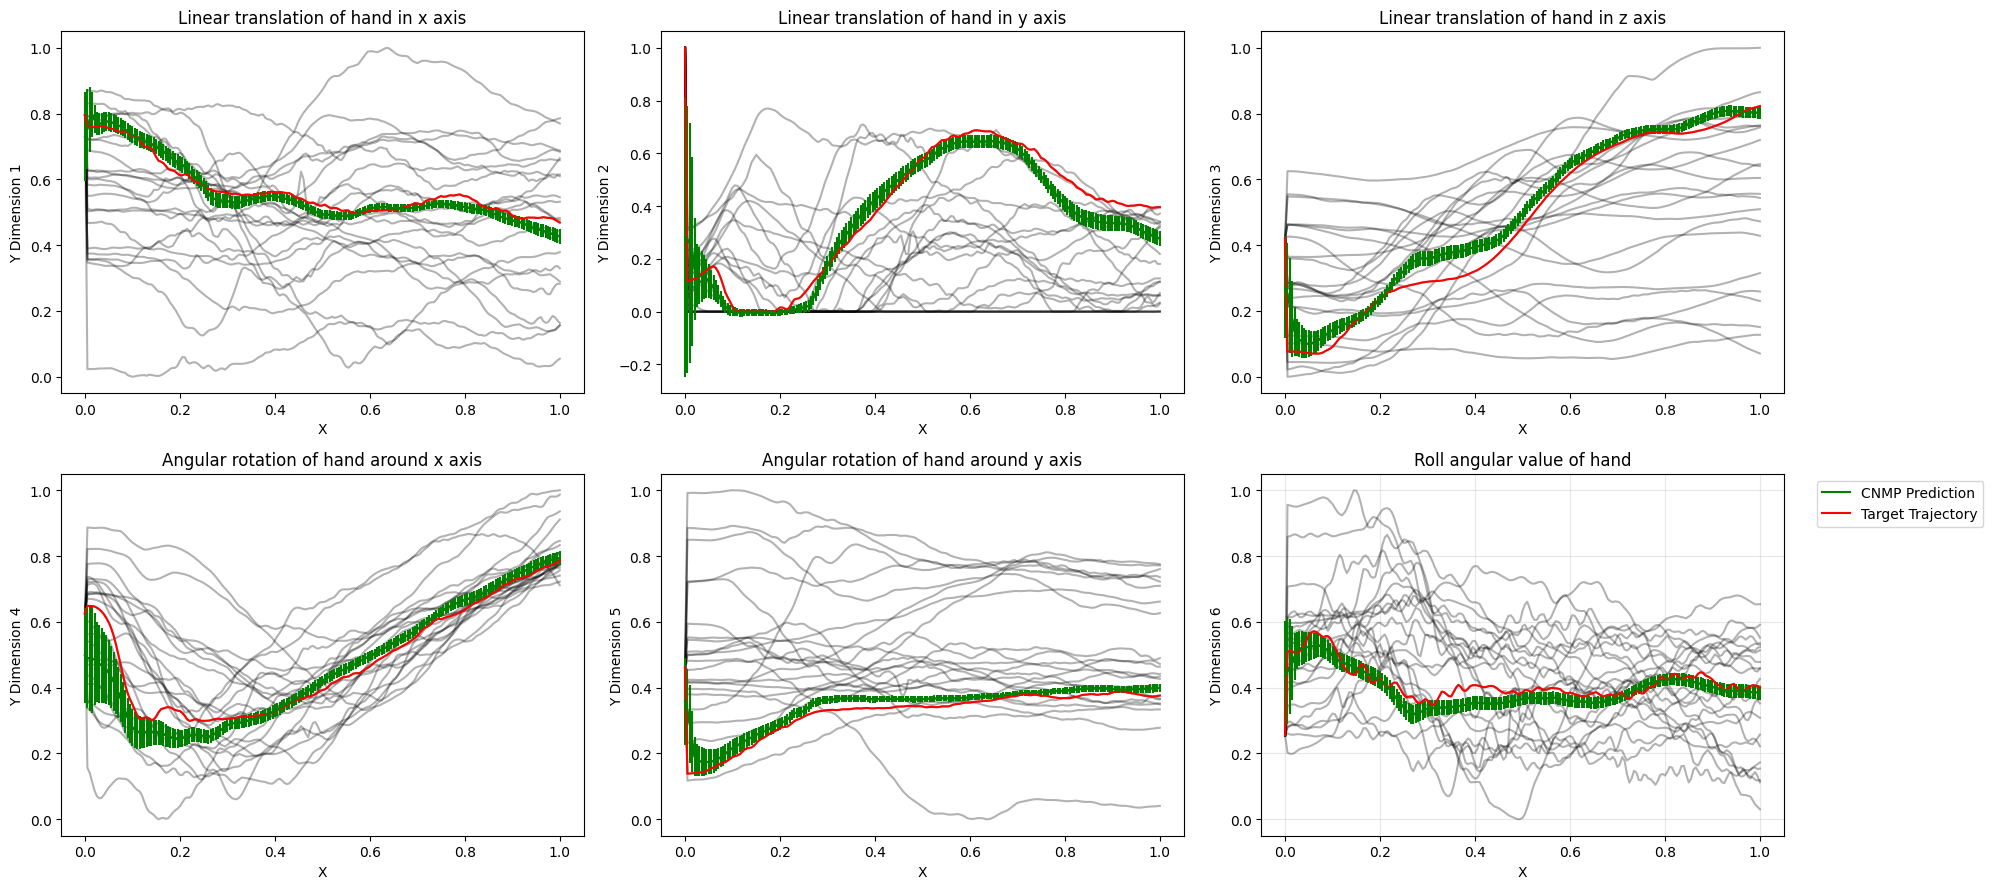

Hand to ball: [1.66164342e-01 2.93248028e-01 5.55111508e-09] 
Ball position: [] 
Target position: []


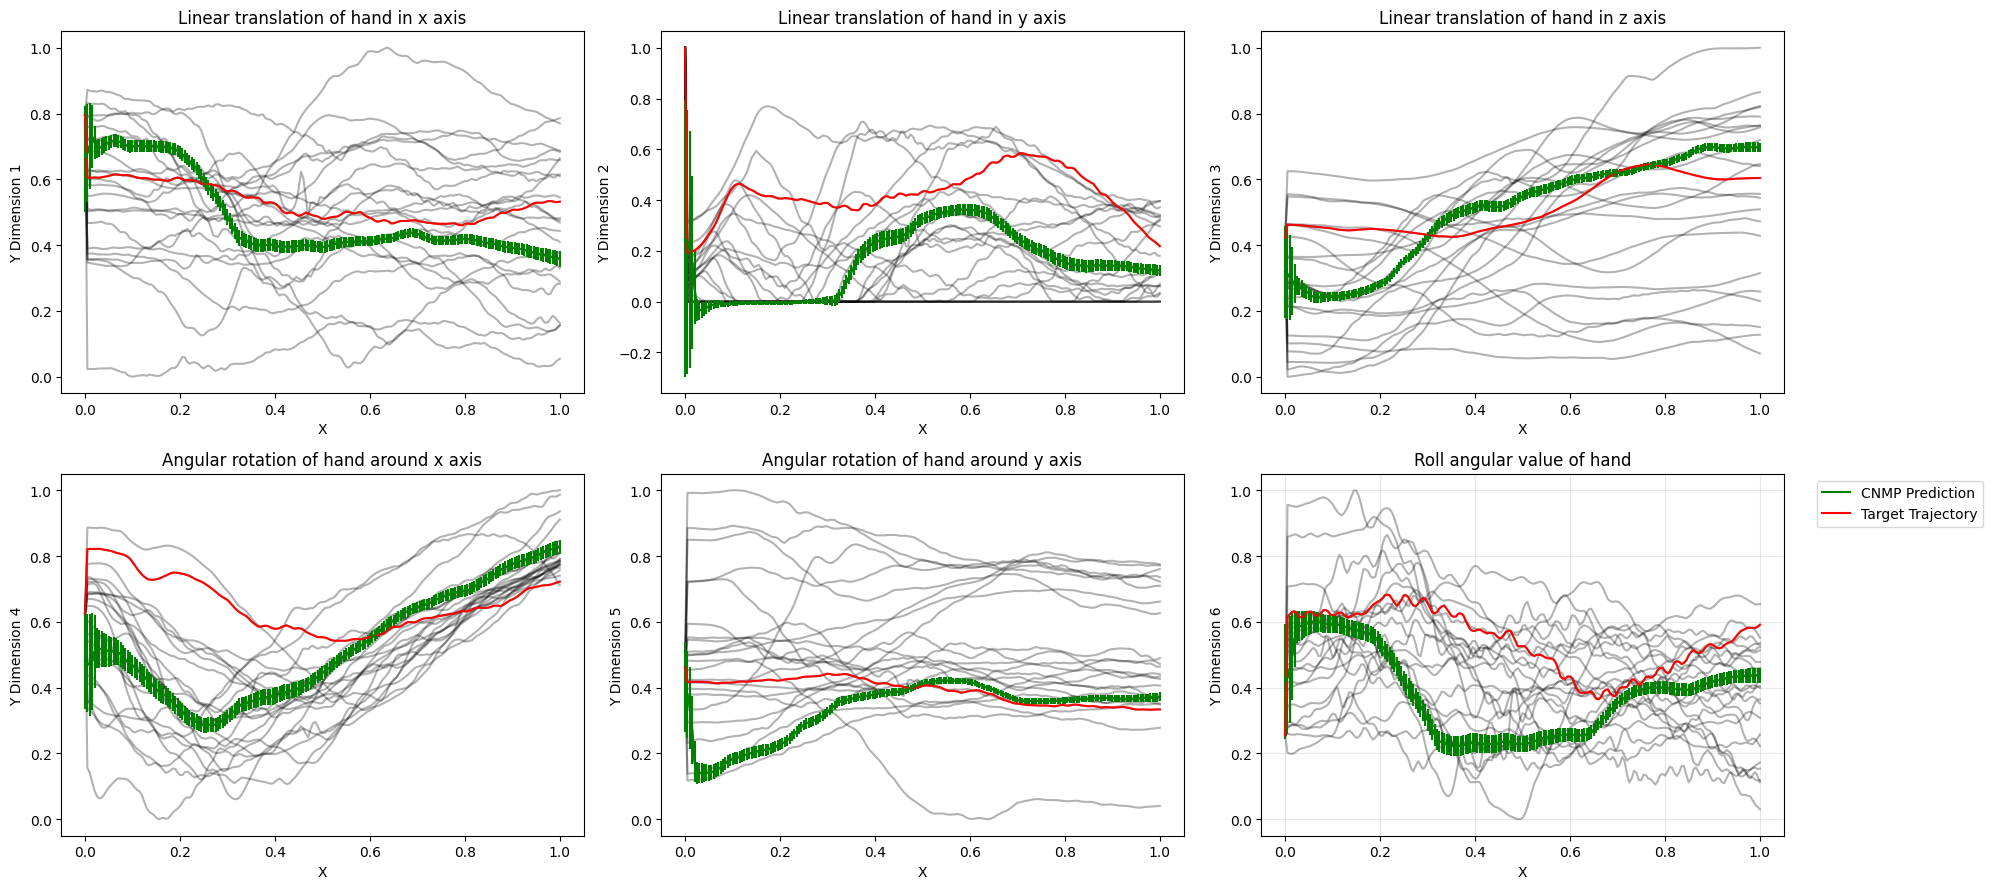

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class CNMP(nn.Module):
    def __init__(self, d_x, d_y, d_SM):
        super(CNMP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(d_x + d_y, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Linear(64, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Linear(64, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Linear(128, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 256),
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_x + (6) + 256, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Linear(128, 2 * d_SM)  # Output mean and std for
        )
    def forward(self, obs, context, mask, x_tar): # obs is (n, d_x + d_y)

        r = self.encoder(obs)
        masked_r = torch.bmm(mask, r)
        masked_r_sum = torch.sum(masked_r, dim=1, keepdim=True)  # (1, 128)
        r_avg = masked_r_sum / torch.sum(mask, dim=[1,2], keepdim=True)  # (1, 128)
        r_avg = r_avg.repeat(1, x_tar.shape[1], 1)
        context = context.unsqueeze(1).repeat(1, x_tar.shape[1], 1)  # (n, 1, 9)
        concat = torch.cat((r_avg, context, x_tar), dim=-1)
        #concat = torch.cat((r_avg, x_tar), dim=-1)
        output = self.decoder(concat) # (2*d_y,)
        return output, r_avg

def generate_trajectory(model, obs, context):
    obs = torch.tensor(obs, dtype=torch.float64).unsqueeze(0)  # (1, 1, d_x + d_y)
    mask = torch.ones((1, obs.shape[1], obs.shape[1]), dtype=torch.float64)
    context = torch.tensor(context, dtype=torch.float64).unsqueeze(0)  # (1, 15)
    x_tar = torch.linspace(0, 1, time_len).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        output, _ = model(obs, context, mask, x_tar)
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    return mean, std

best_model = CNMP(d_x=1, d_y=6, d_SM=6).double()
best_model.load_state_dict(torch.load('save/best_models_reach_arm/model.pth'))
best_model.eval()
 
time_len = 201

action_data = np.load('data/reach_arm_actions.npy')  # shape (25, 451, 30)
observation_data = np.load('data/reach_arm_observations.npy')  # shape (25, 451, 42)

print('Action data shape:', action_data.shape)

train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] # use all trajectories for training
val_indices = [] 

num_data = len(train_indices)

X = np.tile(np.linspace(0, 1, time_len).reshape((1, time_len, 1)), (len(train_indices), 1, 1))  # 25 trajectories
Y = np.zeros((len(train_indices), time_len, 6))
Y[:, 1:] = action_data[train_indices]
C = np.zeros((len(train_indices), 6))
for i in range(len(train_indices)):
    C[i, :3] = observation_data[train_indices[i], 0, 30:33]
    C[i, 3:] = observation_data[train_indices[i], 0, 42:45]  # add the first observation as context

VAL_Y = np.zeros((len(val_indices), time_len, 6))
VAL_Y[:, 1:] = action_data[val_indices]
VAL_C = np.zeros((len(val_indices), 6))
for i in range(len(val_indices)):
    VAL_C[i, :3] = observation_data[val_indices[i], 0, 30:33]
    VAL_C[i, 3:] = observation_data[val_indices[i], 0, 42:45]  # add the first observation as context

# normalize Y and C by dimensions
for dim in range(Y.shape[-1]):
    Y_min = np.min(Y[:, :, dim], axis=(0, 1), keepdims=True)
    Y_max = np.max(Y[:, :, dim], axis=(0, 1), keepdims=True)
    Y[:, :, dim] = (Y[:, :, dim] - Y_min) / (Y_max - Y_min + 1e-8)
    VAL_Y[:, :, dim] = (VAL_Y[:, :, dim] - Y_min) / (Y_max - Y_min + 1e-8)

for dim in range(C.shape[-1]):
    C_min = np.min(C[:, dim], axis=0, keepdims=True)
    C_max = np.max(C[:, dim], axis=0, keepdims=True)
    C[:, dim] = (C[:, dim] - C_min) / (C_max - C_min + 1e-8)
    VAL_C[:, dim] = (VAL_C[:, dim] - C_min) / (C_max - C_min + 1e-8)

for idx in [0, 1, 2]:

    cnmp_obs = []
    num_obs = 1
    for i in range(num_obs):
        cnmp_obs.append(np.concatenate((X[0, i, :], Y[idx, i, :]), axis=-1))
    cnmp_obs = np.array(cnmp_obs, dtype=np.float64)  # shape (20, 1, d_x + d_y)

    context = C[idx, :]

    print("Hand to ball:", C[idx, :3],
            #"\nBall to target:", C[idx, 3:6],
            #"\nHand to target:", C[idx, 6:9],
            "\nBall position:", C[idx, 9:12],
            "\nTarget position:", C[idx, 12:15])

    mean, std = generate_trajectory(best_model, cnmp_obs, context)
    plt.figure(figsize=(20, 9))
    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2)
    ax3 = plt.subplot(2, 3, 3)
    ax4 = plt.subplot(2, 3, 4)
    ax5 = plt.subplot(2, 3, 5)
    ax6 = plt.subplot(2, 3, 6)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    titles = ['Linear translation of hand in x axis',
              'Linear translation of hand in y axis',
              'Linear translation of hand in z axis',
              'Angular rotation of hand around x axis',
              'Angular rotation of hand around y axis',
              'Roll angular value of hand']

    for i in range(num_data):
        for dim in range(6):
            axes[dim].plot(X[i, :, 0], Y[i, :, dim], color='black', alpha=0.3)

    for dim in range(6):
        axes[dim].errorbar(X[0, :, 0], mean[0, :, dim].numpy(), yerr=std[0, :, dim].numpy(), 
                        color='green', alpha=1.0)
        axes[dim].plot(X[0, :, 0], mean[0, :, dim].numpy(), color='green', label='CNMP Prediction')
        axes[dim].plot(X[0, :, 0], Y[idx, :, dim], color='red', label='Target Trajectory')
        axes[dim].set_title(titles[dim])
        axes[dim].set_xlabel('X')
        axes[dim].set_ylabel(f'Y Dimension {dim + 1}')
    axes[dim].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[dim].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    #plt.savefig(f'cnmp_prediction_{idx}_state_action.png', bbox_inches='tight')
    


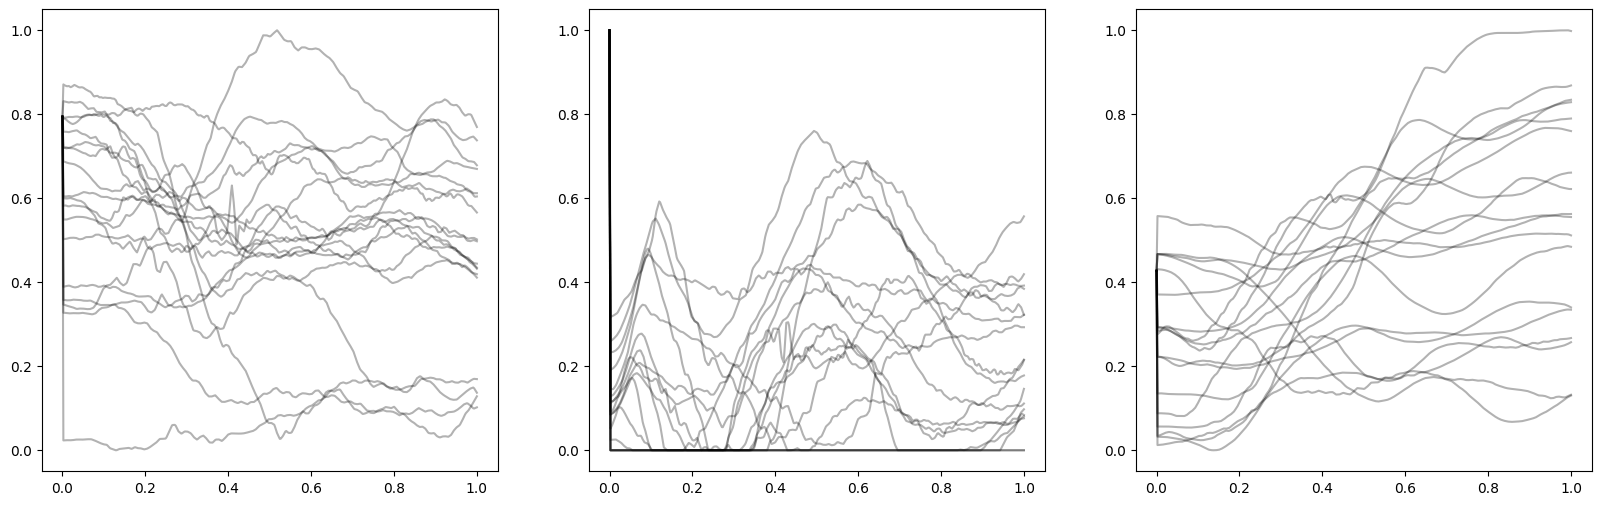

In [49]:
# plot hand to target, ball to target, hand to ball, hand position, ball position, target position in 6 plots each with 3 dimensions for all trajectories

plt.figure(figsize=(20, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
axes = [ax1, ax2, ax3]
titles = ['Linear translation of hand in x axis',
            'Linear translation of hand in y axis',
            'Linear translation of hand in z axis']

for i in range(18):
    for dim in range(3):
        axes[dim].plot(X[i, :, 0], Y[i, :, dim], color='black', alpha=0.3)

plt.show()